# **05. 머신러닝 회귀분석**

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.feature_selection import f_regression, chi2, SelectKBest
from catboost import CatBoostRegressor
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings("ignore")

font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams['font.family'] = font_family
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

apartment = pd.read_csv("regression_data.csv")
apartment.drop(columns=['평당_공급액'], axis=1, inplace=True)

In [66]:
y = apartment['공급액']
X = apartment.drop(['공급액'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((2270, 135), (568, 135))

**Feature Selection**

1 features
Selected_columns:  Index(['공급면적'], dtype='object')
Test MAE: 19,869
Test R2: 0.3341396947420813 

2 features
Selected_columns:  Index(['공급면적', '전용면적'], dtype='object')
Test MAE: 19,614
Test R2: 0.3492496129597721 

3 features
Selected_columns:  Index(['최대공급면적', '공급면적', '전용면적'], dtype='object')
Test MAE: 19,528
Test R2: 0.3534477241083275 

4 features
Selected_columns:  Index(['최대공급면적', '공급면적', '전용면적', '대형건설사'], dtype='object')
Test MAE: 18,892
Test R2: 0.3858716959200519 

5 features
Selected_columns:  Index(['최대공급면적', '공급면적', '전용면적', '대형건설사', '분양가상한제_after'], dtype='object')
Test MAE: 17,861
Test R2: 0.49332153647294963 

6 features
Selected_columns:  Index(['최대공급면적', '공급면적', '전용면적', '대형건설사', '투기과열지구_after', '분양가상한제_after'], dtype='object')
Test MAE: 17,861
Test R2: 0.49332153647294974 

7 features
Selected_columns:  Index(['최대공급면적', '공급면적', '전용면적', '욕실수', '대형건설사', '투기과열지구_after',
       '분양가상한제_after'],
      dtype='object')
Test MAE: 17,753
Test R2: 0.4909900794619566 

8

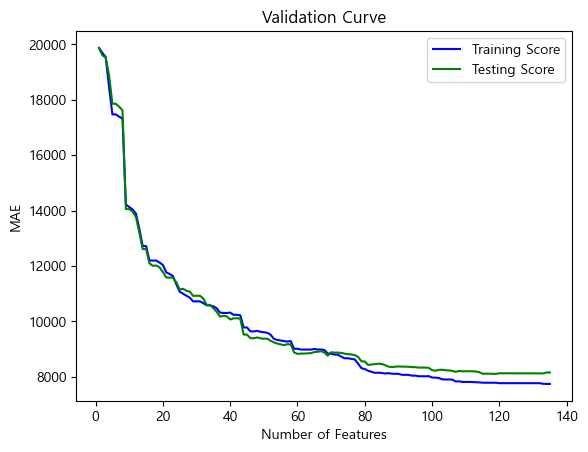

In [67]:
training = []
testing = []
k_selected_columns = [] 
k_number = range(1, len(X_train.columns)+1) 

for k in range(1, len(X_train.columns)+ 1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    all_names = X_train.columns
    selected_mask = selector.get_support()
    selected_columns = all_names[selected_mask]
    k_selected_columns.append(selected_columns)
    print('Selected_columns: ', selected_columns)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_train_selected)
    mae = mean_absolute_error(y_train, y_pred)
    training.append(mae)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    testing.append(mae)
    print(f'Test MAE: {mae:,.0f}')
    print(f'Test R2: {r2} \n')

plt.plot(k_number, training, label='Training Score', color='b')
plt.plot(k_number, testing, label='Testing Score', color='g')
plt.ylabel("MAE")
plt.xlabel("Number of Features")
plt.title('Validation Curve')
plt.legend()
plt.show()

K=40으로 결정

In [68]:
final_columns = k_selected_columns[40]
final_columns

Index(['세대수', '최고층', '최대공급면적', '최소공급면적', '총아파트동수', '세대평균_주차대수', '공급면적', '전용면적',
       '방수', '욕실수', '대형건설사', '지하철역_거리', '병원_1차', '병원_2차', '병원_3차', '대학', '교육',
       '장례식장', '보건의료', '투기과열지구_after', '분양가상한제_after', '투기과열지구_before',
       '분양가상한제_before', '타시군구_시군구내', '타입', '광역_경기', '광역_서울', '기초_경기_양주시',
       '기초_경기_평택시', '기초_서울_강남구', '기초_서울_강동구', '기초_서울_광진구', '기초_서울_동작구',
       '기초_서울_서초구', '기초_서울_용산구', '기초_인천_연수구', '입주예정연도_2025', '노선_9호선',
       '노선_인천_1호선', '노선_수인선', '노선_3호선'],
      dtype='object')

**Feature Scaling**

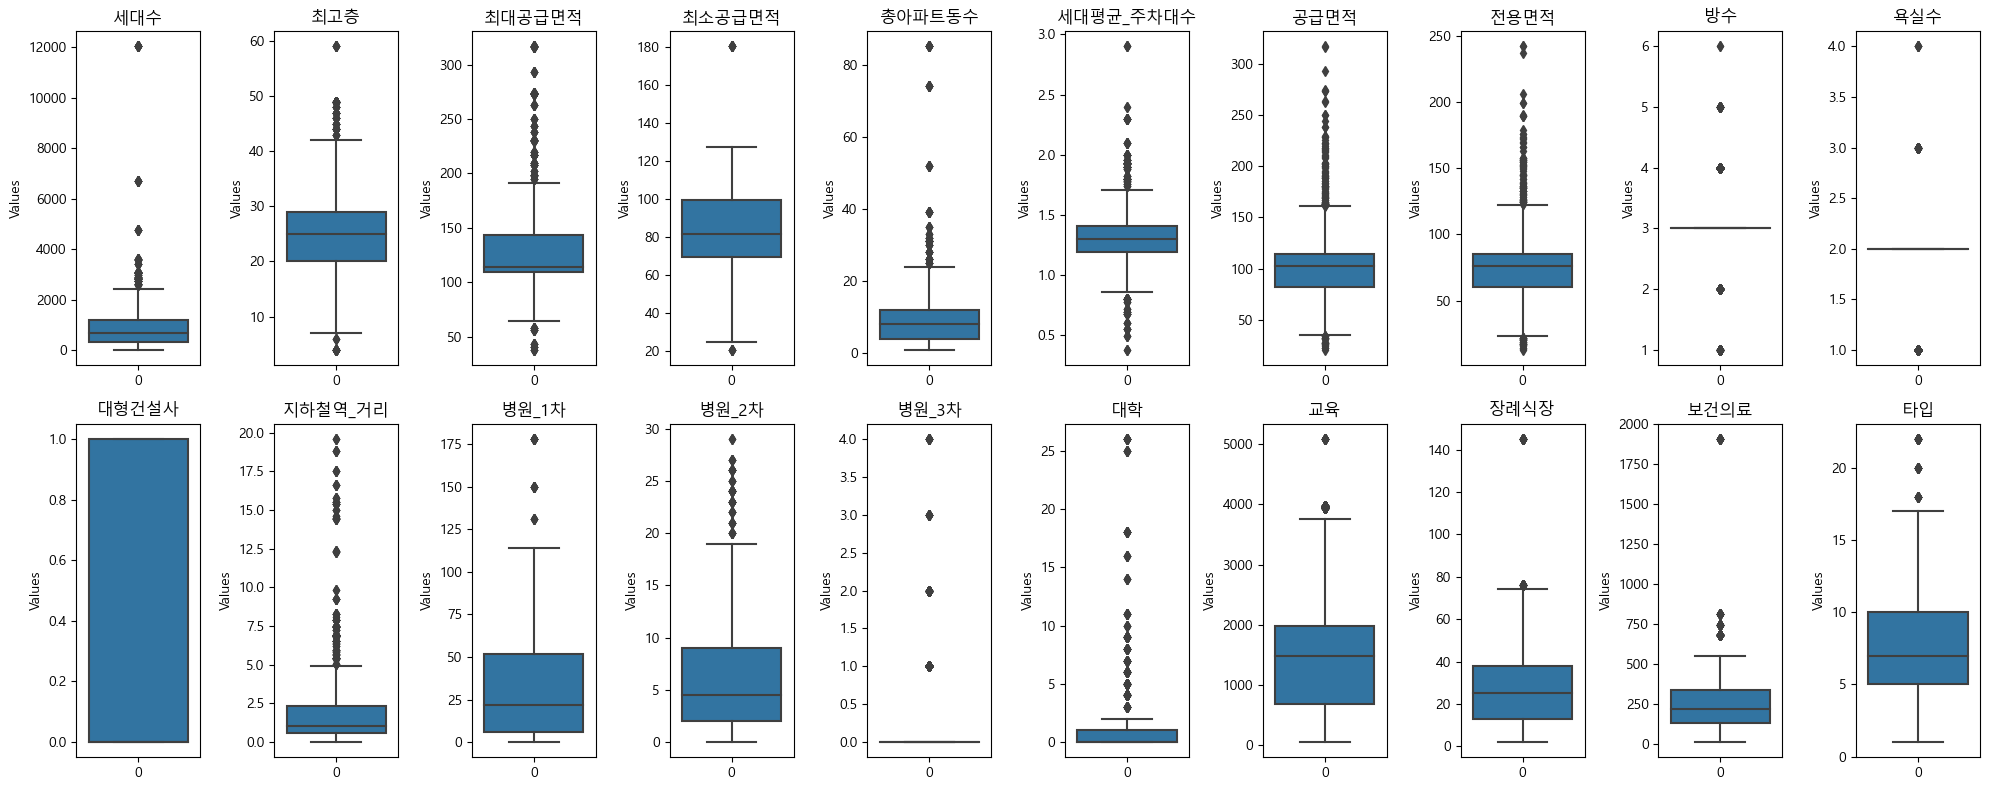

In [69]:
final_columns_continuous = ['세대수', '최고층', '최대공급면적', '최소공급면적', '총아파트동수', '세대평균_주차대수', '공급면적', '전용면적',
       '방수', '욕실수', '대형건설사', '지하철역_거리', '병원_1차', '병원_2차', '병원_3차', '대학', '교육', '장례식장', '보건의료', '타입']

fig, axs = plt.subplots(figsize=(20, 8), ncols=10, nrows=2)

for i, feature in enumerate(final_columns_continuous):
    row = int(i/10)
    col = i % 10
    
    sns.boxplot(apartment[feature], orient="v", ax=axs[row][col])
    axs[row][col].set_title(feature)  
    axs[row][col].set_xlabel("") 
    axs[row][col].set_ylabel("Values") 
    
plt.tight_layout()
plt.show() 


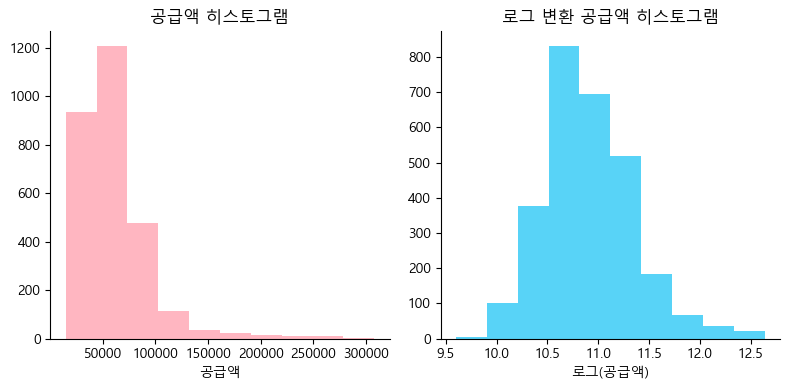

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].hist(apartment['공급액'], color='#FFB6C1')
axs[0].set_title('공급액 히스토그램')
axs[0].set_xlabel('공급액')

axs[1].hist(np.log1p(apartment['공급액']), color = '#58D3F7')
axs[1].set_title('로그 변환 공급액 히스토그램')
axs[1].set_xlabel('로그(공급액)')

sns.despine()
plt.tight_layout() 
plt.show() 


**타겟값 로그변환 후 모델링**

In [71]:
scalers = [StandardScaler(), MinMaxScaler()]
models = {'lr_reg': LinearRegression(),
         'rf_reg': RandomForestRegressor(),
         'xgb_reg': XGBRegressor(),
         'lgmb_reg': LGBMRegressor(force_col_wise=True),
         'cat_reg': CatBoostRegressor(verbose=False)}

result = []

for scaler in scalers:
    y = np.log1p(apartment['공급액'])
    X = apartment[final_columns]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred_log = model.predict(X_test_scaled)
        y_pred = np.expm1(y_pred_log)
        y_test_original = np.expm1(y_test)
        
        mae = mean_absolute_error(y_test_original, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
        r2 = r2_score(y_test_original, y_pred)
        rmsle = np.sqrt(mean_squared_log_error(y_test_original, y_pred_log))
        
        result.append([model_name, scaler, mae, rmse, r2, rmsle])
        result_df = pd.DataFrame(result, columns=['model', 'scaler', 'mae', 'rmse', 'r2', 'rmsle']).sort_values('rmsle', ascending=True)

result_df    

,model,scaler,mae,rmse,r2,rmsle
0,lr_reg,StandardScaler(),8648.880948,13206.351762,0.831804,8.424623
5,lr_reg,MinMaxScaler(),8648.880948,13206.351762,0.831804,8.424623
2,xgb_reg,StandardScaler(),2904.153953,5800.457090,0.967553,8.424823
7,xgb_reg,MinMaxScaler(),2904.153953,5800.457090,0.967553,8.424823
4,cat_reg,StandardScaler(),2951.542661,5468.615471,0.971159,8.424911
9,cat_reg,MinMaxScaler(),2951.542661,5468.615471,0.971159,8.424911
1,rf_reg,StandardScaler(),3929.315118,7403.251710,0.947144,8.425133
6,rf_reg,MinMaxScaler(),3938.076587,7639.946579,0.943710,8.425175
8,lgmb_reg,MinMaxScaler(),3591.105619,6732.311687,0.956290,8.425195
3,lgmb_reg,StandardScaler(),3699.936283,7014.965746,0.952543,8.425397


**모델 선택과 하이퍼파라미터 조정**

In [74]:
scalers = [StandardScaler(), MinMaxScaler()]

models = {'rf_reg': RandomForestRegressor(),
          'cat_reg': CatBoostRegressor(verbose=0)}

regressors_parameters = {
    'rf_reg': {'n_estimators': [300, 500, 700],
                'max_depth': [3, 6, 9],
                'max_features': [20, 30, 40]},
    'cat_reg': {'iterations': [300, 500, 700],
                'depth': [6, 8, 10],
                'learning_rate': [0.01, 0.1, 0.2]}}

def get_hyperparameter_search(models, regressors_parameters):
    result =[]
    for scaler in [StandardScaler(), MinMaxScaler()]:
        y = np.log1p(apartment['공급액'])
        X = apartment[final_columns]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        for reg, params in regressors_parameters.items():
            model = models[reg]
            param_grid = ParameterGrid(params)
            
            for param in param_grid:
                scores = []

                if reg == 'cat_reg':
                    new_model = CatBoostRegressor(verbose=0, **param)
                    new_model.fit(X_train_scaled, y_train)
                    y_pred_log = new_model.predict(X_test_scaled)
                else:
                    model.set_params(**param)
                    model.fit(X_train_scaled, y_train)
                    y_pred_log = model.predict(X_test_scaled)
                
                y_pred = np.expm1(y_pred_log)
                y_test_original = np.expm1(y_test)
                
                mae = mean_absolute_error(y_test_original, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
                r2 = r2_score(y_test_original, y_pred)
                rmsle = np.sqrt(mean_squared_log_error(y_test_original, y_pred_log))
                
                result.append({'model': reg, 'scaler': str(scaler), 'parameter': param, 'mae': mae, 'rmse': rmse, 'r2': r2, 'rmsle': rmsle})

    result = pd.DataFrame(result).sort_values('rmsle', ascending=True)
    return result

wanted = get_hyperparameter_search(models, regressors_parameters)
wanted

,model,scaler,parameter,mae,rmse,r2,rmsle
54,rf_reg,MinMaxScaler(),"{'max_depth': 3, 'max_features': 20, 'n_estima...",13261.160047,19588.745811,0.629948,8.424392
55,rf_reg,MinMaxScaler(),"{'max_depth': 3, 'max_features': 20, 'n_estima...",13388.690759,19724.247008,0.624811,8.424417
2,rf_reg,StandardScaler(),"{'max_depth': 3, 'max_features': 20, 'n_estima...",13366.774610,19732.868782,0.624483,8.424432
56,rf_reg,MinMaxScaler(),"{'max_depth': 3, 'max_features': 20, 'n_estima...",13367.080574,19721.583556,0.624912,8.424434
1,rf_reg,StandardScaler(),"{'max_depth': 3, 'max_features': 20, 'n_estima...",13348.295874,19761.597216,0.623389,8.424451
...,...,...,...,...,...,...,...
25,rf_reg,StandardScaler(),"{'max_depth': 9, 'max_features': 40, 'n_estima...",5530.546169,8990.353822,0.922052,8.425168
50,cat_reg,StandardScaler(),"{'depth': 10, 'iterations': 500, 'learning_rat...",2562.664761,5545.056333,0.970347,8.425180
104,cat_reg,MinMaxScaler(),"{'depth': 10, 'iterations': 500, 'learning_rat...",2560.324119,5544.046636,0.970358,8.425184
53,cat_reg,StandardScaler(),"{'depth': 10, 'iterations': 700, 'learning_rat...",2563.639108,5559.963843,0.970188,8.425186


In [77]:
top = pd.json_normalize(wanted[:1]['parameter'])
top

,max_depth,max_features,n_estimators
0,3,20,300


**Model: rf_reg, Scaler: MinMaxScaler(), Parameter: {'max_depth': 3, 'max_features': 20, 'n_estimators': 300}**

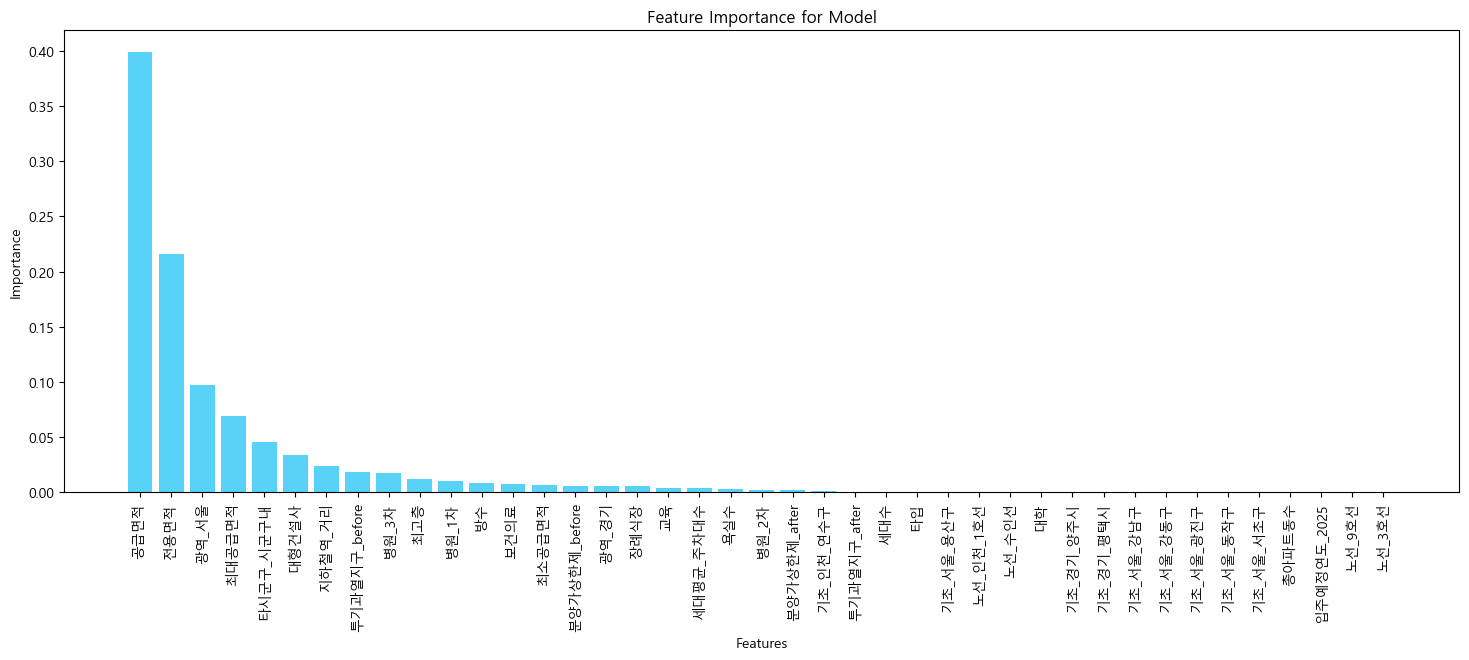

In [96]:
feature_importance_list = []

top_models = wanted.head(1) 

for index, row in top_models.iterrows():
    model_name = row['model']
    scaler_name = row['scaler']
    parameters = row['parameter']
    
    model = models[model_name]
    model.set_params(**parameters)
    
    scaler = StandardScaler() if scaler_name == "StandardScaler()" else MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)

    feature_importances = model.feature_importances_

    importance_df = pd.DataFrame({'Feature': final_columns, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(18, 6))
    plt.bar(importance_df['Feature'], importance_df['Importance'], color= '#58D3F7')
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.title("Feature Importance for Model")
    plt.xticks(rotation=90)
    plt.show()
